In [25]:
import matplotlib.pyplot as plt
import numpy as np
from PSP_heat import *
from PSP_thermalCond import *
from PSP_soil import *
from math import *
from __future__ import print_function, division
import matplotlib.pyplot as plt
import PSP_grid as grid
from PSP_ThomasAlgorithm import *
from PSP_heatSoil import *

## For testing purpose

In [26]:
thermalConductivity (1400, 0.2, 0.2, 20)

0.8187033652811866

In [27]:
thermalConductivity (1500, 0.2, 0.2, 25)

0.9708215404025108

In [28]:
thermalConductivity (1400, 0.2, 0.2, 35)

0.9770680304926195

### 4.1. Use the function thermalConductivity to investigate the temperature dependence  of thermal conductivity.
### At what temperature is the thermal conductivity of we  soil independent of water content?e

Text(0.5, 1.0, 'Thermal Conductivity vs Temperature')

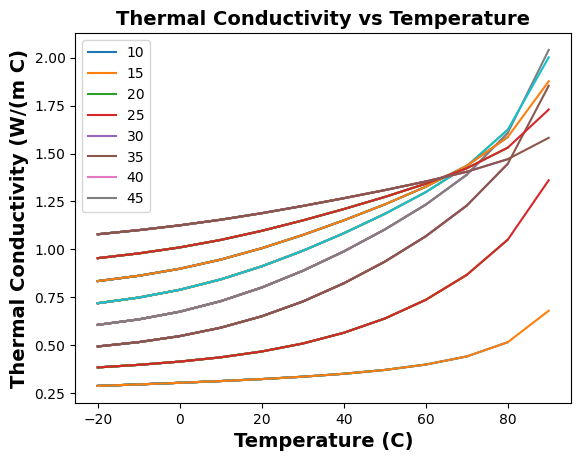

In [29]:
bulkDensity=1300
waterContent=range(10,50,5)
clay=.4
temperature = range(-20,95,10)
ypoints = []
theta_points = []
for y in waterContent:
    ypoints.append(y)
    xpoints =[]
    K_therm = []
    for x in temperature:
        K= thermalConductivity(bulkDensity, y/100 , clay, x)
        xpoints.append(x)
        K_therm.append(K)
        plt.plot(xpoints,K_therm,label = str(y))
plt.xlabel('Temperature (C)', fontweight='bold', fontsize=14)
plt.ylabel('Thermal Conductivity (W/(m C)', fontweight='bold', fontsize=14)
plt.legend((ypoints))
plt.title('Thermal Conductivity vs Temperature', fontweight='bold', fontsize=14)

### 4.2 What is the possible range of volumetric specific heat in mineral soils?

In [30]:
#Note: Ch is strongly dependent on volumetric water content 

Db_min = 1000     # assumed minimum bulk density value[Kg/m3]

Db_max = 1800     # assumed maximum bulk density value [Kg/m3]

Dp = 2650         # assumed particle density value (from quartz) [Kg/m3]

Cs = 2.4e6        # volumetric_heat_capacity of solids [J/m3/K]
                  # usual value for mineral soils (from Table 4.1 -p. 65)

Cl = 4.18e6       # volumetric_heat_capacity of liquid [J/m3/K]
                  # from Table 4.1 -p. 65

#Formulas

Vf_Dbmin = 1 - (Db_min/Dp)    # volume fraction of pores with minimum bulk density value (1000 kg/m3) [m3/m3]
Vf_Dbmax = 1 - (Db_max/Dp)    # volume fraction of pores with maximum bulk density value (1800 kg/m3) [m3/m3]

Sf_Dbmin = 1 - Vf_Dbmin       # volume_fraction of solids with minimum bulk density value (1000 kg/m3) [m3/m3]
Sf_Dbmax = 1 - Vf_Dbmax       # volume_fraction of solids with maximum bulk density value (1800 kg/m3) [m3/m3]

Lf_Dbminsat = Vf_Dbmin        # volume fraction of liquid with minimum bulk density value (1000 kg/m3) at saturation [m3/m3] 

Lf_Dbmaxsat = Vf_Dbmax        # volume fraction of liquid with maximum bulk density value (1800 kg/m3) at saturation [m3/m3]

Lf_Dbmin10 = Vf_Dbmin * 0.1   # volume fraction of liquid with minimum bulk density value (1000 kg/m3) at 10% volumetric water content [m3/m3]

Lf_Dbmax10 = Vf_Dbmax * 0.1   # volume fraction of liquid with maximum bulk density value (1800 kg/m3) at 10% volumetric water content [m3/m3]


#Calculation of Ch for each soil with different Db and volumetric water content values

Ch_Dbminsat = Cs * Sf_Dbmin + Cl * Lf_Dbminsat    # total volumetric_heat_capacity of soil with minimum bulk density value (1000 kg/m3) at saturation [J/m3/K]
Ch_Dbmaxsat = Cs * Sf_Dbmax + Cl * Lf_Dbmaxsat    # total volumetric_heat_capacity of soil with maximum bulk density value (1800 kg/m3) at saturation [J/m3/K]
Ch_Dbmin10 = Cs * Sf_Dbmin + Cl * Lf_Dbmin10      # total volumetric_heat_capacity of soil with minimum bulk density value (1000 kg/m3) at 10% volumetric water content [J/m3/K]
Ch_Dbmax10 = Cs * Sf_Dbmax + Cl * Lf_Dbmax10      # total volumetric_heat_capacity of soil with maximum bulk density value (1800 kg/m3) at 10% volumetric water content [J/m3/K]

print ('%E' % (Ch_Dbminsat), ' = maximum Ch value')
print ('%E' % (Ch_Dbmaxsat))
print ('%E' % (Ch_Dbmin10), ' = minimum Ch value')
print ('%E' % (Ch_Dbmax10))

3.508302E+06  = maximum Ch value
2.970943E+06
1.165925E+06  = minimum Ch value
1.764264E+06


### 4.4 Modify the program PSP_heat.py so that it allows water content to change with depth. Then compare simulations for uniform, dry soil with simulations of a moist soil with a dry dust mulch on the surface


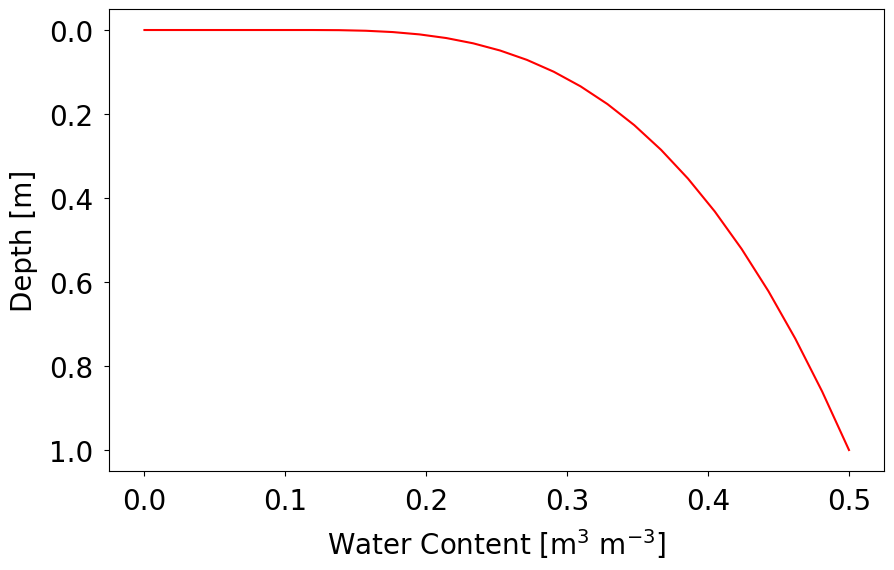

In [31]:
area = 1                    	
maxNrIterations = 100
tolerance = 1.e-2               
T_0 = 25                                  #Assumed initial temperature
n = 20                        
z = np.zeros(n+2, float)  
zCenter = np.zeros(n+2, float)      
dz = np.zeros(n+2, float)       
vol = np.zeros(n+2, float)     
wc = np.zeros(n+2, float)       
a = np.zeros(n+2, float)        
b = np.zeros(n+2, float)        
c = np.zeros(n+2, float)        
d = np.zeros(n+2, float)       

T = np.zeros(n+2, float)      
dT = np.zeros(n+2, float)       
oldT = np.zeros(n+2, float)     
C_T = np.zeros(n+2, float)     
lambda_ = np.zeros(n+2, float)  
k_mean = np.zeros(n+2, float)   
f = np.zeros(n+2, float)       

def initialize(T_0, thetaIni, solver):
    global z, dz, zCenter, vol, wc, T, oldT
    # vector depth [m]
    z = grid.geometric(n, 1.0)
  
    vol[0] = 0
    for i in range(n+1): 
        dz[i] = z[i+1]-z[i]
        if (i > 0): vol[i] = area * dz[i]
    for i in range(n+2): 
        zCenter[i] = z[i] + dz[i]*0.5
        
    if (solver == CELL_CENT_FIN_VOL):
        for i in range(n+1): 
            dz[i] = zCenter[i+1]-zCenter[i]
                 
    for i in range(1, n+2):
        T[i] = T_0
        oldT[i] = T_0
        wc[i] = thetaIni[i]               #Set water content with depth
    return z

thetaIni = np.linspace(0.1, 0.5, n+2)  
initialize(T_0, thetaIni, solver)

def finiteDifference(airT, boundaryT, dt, factor):
    g = 1.0 - factor
    energyBalance = 1.
    for i in range(1, n+2):
        T[i] = oldT[i]
    nrIterations = 0
    while ((energyBalance > tolerance) and (nrIterations < maxNrIterations)):
        for i in range(1, n+2):
            #lambda_[0]= 20.
            lambda_[i] = thermalConductivity(bulkDensity, wc[i], clay, T[i])
            C_T[i] = heatCapacity(bulkDensity, wc[i])*vol[i]
        f[0] = 0.
        for i in range(1, n+1):
            f[i]=area* lambda_[i] / dz[i]
        for i in range(1, n+1):    
            if (i == 1):
                a[i] = 0.
                b[i] = 1.
                c[i] = 0.
                d[i] = airT
            elif (i < n):
                a[i] = -f[i-1]*factor
                b[i] = C_T[i]/dt + f[i-1]*factor + f[i]*factor
                c[i] = -f[i]*factor
                d[i] = C_T[i]/dt * oldT[i] +(1.-factor)*(f[i-1]*oldT[i-1]+f[i]
                                            *oldT[i+1]-(f[i-1]+f[i])*oldT[i])
            elif (i == n):
                a[n] = 0.
                b[n] = 1.
                c[n] = 0.
                d[n] = boundaryT 
        ThomasBoundaryCondition(a, b, c, d, T, 1, n)
        dSum = 0
        for i in range(2, n):
            dSum += C_T[i]*(T[i]-oldT[i])
        energyBalance = (abs(dSum - factor*dt*(f[1]*(T[1]-T[2]) 
                    - f[n-1]*(T[n-1]-boundaryT)) - g*dt*(f[1]*(oldT[1]-oldT[2]) 
                    - f[n-1]*(oldT[n-1]-boundaryT))))
        nrIterations += 1
        
    if (energyBalance < tolerance):
        flux = f[1]*(T[1]-T[2])
        return True, nrIterations, flux
    else:
        return False, nrIterations, 0

        
def cellCentFiniteVol(airT, boundaryT, dt):
    energyBalance = 1.
    for i in range(1, n+2):
        T[i] = oldT[i] 
    nrIterations = 0
    while ((energyBalance > tolerance) and (nrIterations < maxNrIterations)):
        for i in range(1, n+2):
            lambda_[i] = thermalConductivity(bulkDensity, wc[i], clay, T[i])
            C_T[i] = heatCapacity(bulkDensity, wc[i])*vol[i]
        f[0] = 0.
        for i in range(1, n+1):
            f[i] = area * kMean(LOGARITHMIC, lambda_[i], lambda_[i+1]) / dz[i]
        for i in range(1, n+1):    
            if (i == 1):
                a[i] = 0.
                b[i] = 1.
                c[i] = 0.
                d[i] = airT
            elif (i < n):
                a[i] = -f[i-1]
                b[i] = C_T[i]/dt + f[i-1] + f[i]
                c[i] = -f[i]
                d[i] = C_T[i]/dt * oldT[i]
            elif (i == n):
                a[n] = 0.
                b[n] = 1.
                c[n] = 0.
                d[n] = boundaryT 
        ThomasBoundaryCondition(a, b, c, d, T, 1, n)
        dSum = 0
        for i in range(2, n):
            dSum += C_T[i]*(T[i]-oldT[i])
        energyBalance = (abs(dSum - f[1]*(T[1]-T[2])*dt 
                           + f[n-1]*(T[n-1]-boundaryT)*dt))
        nrIterations += 1
        
    if (energyBalance < tolerance):
        flux = f[1]*(T[1]-T[2])
        return True, nrIterations, flux
    else:
        return False, nrIterations, 0

plt.figure(figsize=(10, 6))
plt.plot(wc, z, color='red')  
plt.xlabel('Water Content [m$^{3}$ m$^{-3}$]', fontsize=20, labelpad=8)
plt.ylabel('Depth [m]', fontsize=20, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=20, pad=8)
plt.tick_params(axis='both', which='minor', labelsize=20, pad=8)
plt.grid(False)
plt.gca().invert_yaxis()
plt.show()

In [32]:
# Constants
specific_heat_min = 1.5  # Minimum specific heat capacity in MJ/m^3°C
specific_heat_max = 2.5  # Maximum specific heat capacity in MJ/m^3°C

print("Possible range of volumetric specific heat in mineral soils:")
print("Minimum specific heat capacity:", specific_heat_min, "MJ/m^3°C")
print("Maximum specific heat capacity:", specific_heat_max, "MJ/m^3°C")


Possible range of volumetric specific heat in mineral soils:
Minimum specific heat capacity: 1.5 MJ/m^3°C
Maximum specific heat capacity: 2.5 MJ/m^3°C


### 4.5 Modify the program main.py to print on screen soil temperatures at 0.15 and 0.3 m depths

In [33]:
from PSP_thermalCond import *

Temperatures =  [20.3, 20.4, 19.8, 18.0]


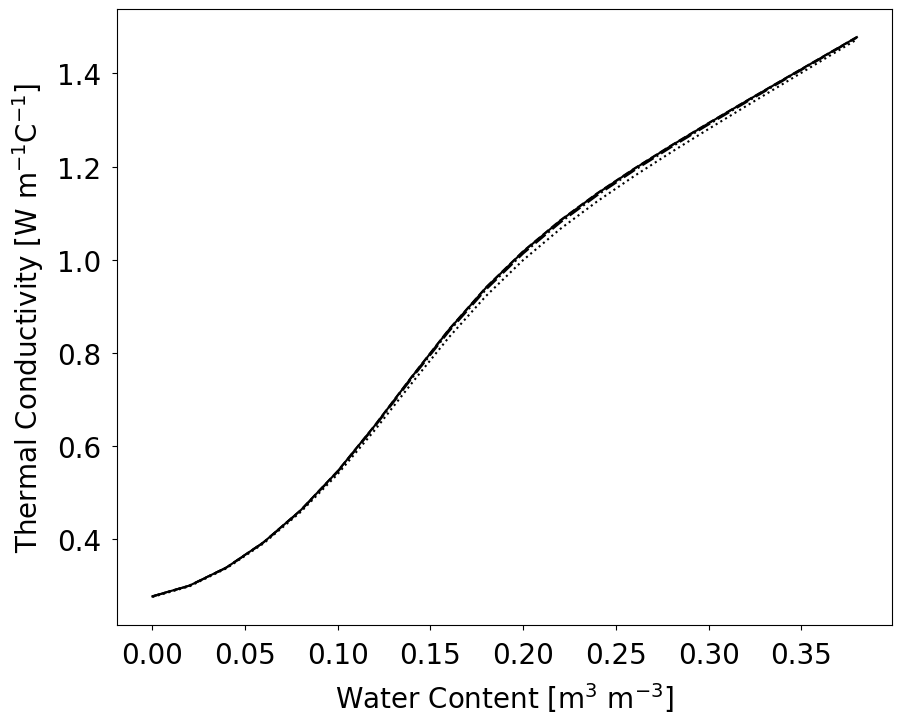

soil temp at 10 cm 20.3
soil temp at 25 cm 20.4


In [34]:
bulkDensity = 1600 # "bulk density [kg/m^3]: "
clay = 0.3 # "clay [0 - 1]: "

A, isFileOk = readDataFile("soilTemperatures_hours.csv", 1, ',', False)

soilTemperature = [A[0][1],A[0][2],A[0][3],A[0][4]] #10 25 70 135 cm
print ("Temperatures = ", soilTemperature)
nrTemperatures = len(soilTemperature)

particleDensity = 2650
porosity = 1 - (bulkDensity / particleDensity) 

step = 0.02  
nrValues = int(porosity / step) + 1
waterContent = np.zeros(nrValues)
thermalConductivitys = np.zeros(nrValues)  ###########after an hour. rename this as it is the name of the command as well
for i in range(nrValues):
    waterContent[i] = step*i


fig = plt.figure(figsize=(10,8))
plt.xlabel('Water Content [m$^{3}$ m$^{-3}$]',fontsize=20,labelpad=8)
plt.ylabel('Thermal Conductivity [W m$^{-1}$C$^{-1}$]',fontsize=20,labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
#plt.xlim(0, 0.7)
for t in range(nrTemperatures):
    for i in range(nrValues):
        thermalConductivitys[i] = thermalConductivity(bulkDensity, waterContent[i], clay, soilTemperature[t])
    if (t == 0): plt.plot(waterContent, thermalConductivitys,'k')  
    if (t == 1): plt.plot(waterContent, thermalConductivitys,'--k')   
    if (t == 2): plt.plot(waterContent, thermalConductivitys,'-.k') 
    if (t == 3): plt.plot(waterContent, thermalConductivitys,':k')
plt.show() 
print ('soil temp at 10 cm' , soilTemperature[0])
print ('soil temp at 25 cm' , soilTemperature[1])

### 4.6 Modify the values of clay content and bulk density in the program PSP_soil.py and investigate the effects of these variables on soil temperature. Compare simulations for a sand, a silt loam and clay soil and for a compacted soil (ρb = 1500 kg m–3) and a recently tilled soil (ρb = 900 kg m–3).

In [35]:
from PSP_soil import *

In [38]:
Db= [1500,900]
clay= [0.1,0.3,0.7]
theta = 0.3
temp = 25

for i in Db:
    for j in clay:
        K = thermalConductivity(i, theta, j, temp)
        print('bulk density = ', i, ' clay = ', j, ' conductivity = ', K) 

bulk density =  1500  clay =  0.1  conductivity =  1.1905622999739145
bulk density =  1500  clay =  0.3  conductivity =  1.1862159732171547
bulk density =  1500  clay =  0.7  conductivity =  1.1213825252006733
bulk density =  900  clay =  0.1  conductivity =  0.6278320949527835
bulk density =  900  clay =  0.3  conductivity =  0.621795424005874
bulk density =  900  clay =  0.7  conductivity =  0.5352751195379998
